In [33]:
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

In [129]:
adjclose = yf.download(['AAPL','AMZN','JPM','MS','MSFT','TSLA','TSTRX'], period = '1y')['Adj Close']

[*********************100%***********************]  7 of 7 completed


In [130]:
returns = adjclose.pct_change()*100

In [131]:
(adjclose.pct_change()*100).var()

AAPL      4.812273
AMZN      9.201109
JPM       3.198321
MS        3.608835
MSFT      4.844350
TSLA     17.829892
TSTRX     2.160615
dtype: float64

In [132]:
returns.mean()

AAPL    -0.003844
AMZN    -0.155409
JPM     -0.008908
MS       0.010735
MSFT    -0.010066
TSLA    -0.132362
TSTRX   -0.027633
dtype: float64

In [133]:
returns.corr()

,AAPL,AMZN,JPM,MS,MSFT,TSLA,TSTRX
AAPL,1.000000,0.704449,0.545138,0.664957,0.793506,0.613221,0.879231
AMZN,0.704449,1.000000,0.487480,0.604209,0.758690,0.552712,0.801806
JPM,0.545138,0.487480,1.000000,0.774664,0.498901,0.377325,0.715808
MS,0.664957,0.604209,0.774664,1.000000,0.610244,0.512979,0.813662
MSFT,0.793506,0.758690,0.498901,0.610244,1.000000,0.499978,0.852584
TSLA,0.613221,0.552712,0.377325,0.512979,0.499978,1.000000,0.605480
TSTRX,0.879231,0.801806,0.715808,0.813662,0.852584,0.605480,1.000000


In [134]:
ind_er = adjclose.resample('Y').last().pct_change().mean()
ind_er

AAPL     0.216586
AMZN     0.175000
JPM     -0.044598
MS       0.038064
MSFT     0.138237
TSLA     0.551794
TSTRX    0.044731
dtype: float64

In [135]:
ann_sd = adjclose.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

AAPL     0.346671
AMZN     0.481860
JPM      0.282340
MS       0.300075
MSFT     0.347905
TSLA     0.672076
TSTRX    0.232572
dtype: float64

In [136]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
AAPL,0.216586,0.346671
AMZN,0.175000,0.481860
JPM,-0.044598,0.282340
MS,0.038064,0.300075
MSFT,0.138237,0.347905
TSLA,0.551794,0.672076
TSTRX,0.044731,0.232572


In [137]:
cov_matrix = adjclose.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,AAPL,AMZN,JPM,MS,MSFT,TSLA,TSTRX
AAPL,0.000481,0.000469,0.000213,0.000276,0.000382,0.000573,0.000284
AMZN,0.000469,0.000929,0.000265,0.000348,0.000508,0.000708,0.000359
JPM,0.000213,0.000265,0.000319,0.000263,0.000195,0.000284,0.000188
MS,0.000276,0.000348,0.000263,0.000360,0.000254,0.000411,0.000227
MSFT,0.000382,0.000508,0.000195,0.000254,0.000484,0.000464,0.000276
TSLA,0.000573,0.000708,0.000284,0.000411,0.000464,0.001807,0.000377
TSTRX,0.000284,0.000359,0.000188,0.000227,0.000276,0.000377,0.000216


In [155]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights
num_assets = len(adjclose.columns)
num_portfolios = 500000

In [156]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [157]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(adjclose.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [158]:
portfolios  = pd.DataFrame(data)
portfolios.head() # Dataframe of the 500000 portfolios created

,Returns,Volatility,AAPL weight,AMZN weight,JPM weight,MS weight,MSFT weight,TSLA weight,TSTRX weight
0,0.210624,0.343072,0.129749,0.126895,0.013412,0.147326,0.230454,0.212392,0.139773
1,0.206617,0.343974,0.154643,0.153014,0.096971,0.153414,0.197759,0.210172,0.034026
2,0.193585,0.336028,0.201284,0.200760,0.078086,0.098570,0.049337,0.179718,0.192245
3,0.103107,0.289614,0.043411,0.179424,0.171766,0.218024,0.019688,0.083813,0.283875
4,0.147664,0.316518,0.090119,0.240214,0.112683,0.140458,0.032385,0.126468,0.257674


<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

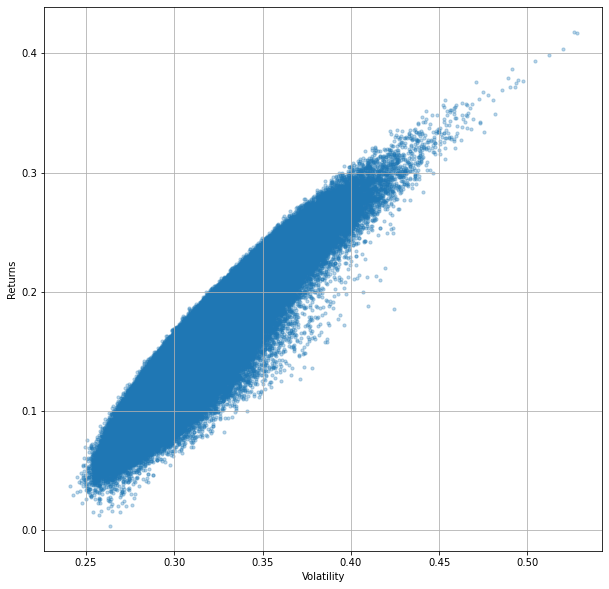

In [159]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])

In [150]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Returns         0.076232
Volatility      0.259972
AAPL weight     0.117525
AMZN weight     0.014858
JPM weight      0.172324
MS weight       0.247823
MSFT weight     0.029301
TSLA weight     0.046689
TSTRX weight    0.371479
Name: 795, dtype: float64

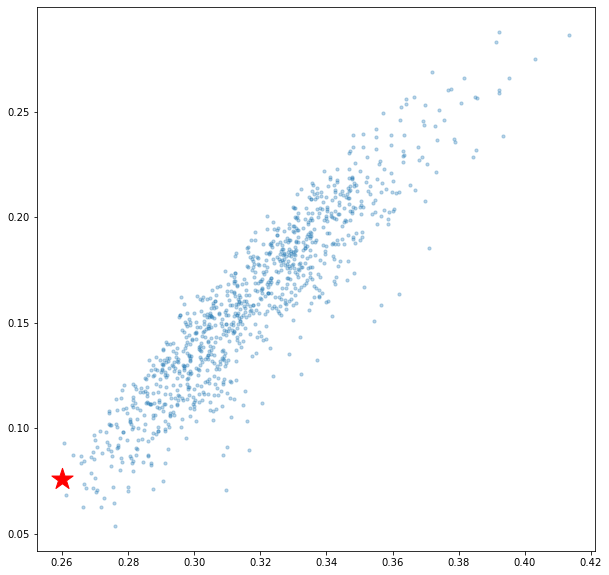

In [151]:
# plotting the minimum volatility portfolio
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)

In [152]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns         0.287782
Volatility      0.392111
AAPL weight     0.426484
AMZN weight     0.156899
JPM weight      0.001352
MS weight       0.079886
MSFT weight     0.025890
TSLA weight     0.290991
TSTRX weight    0.018497
Name: 202, dtype: float64

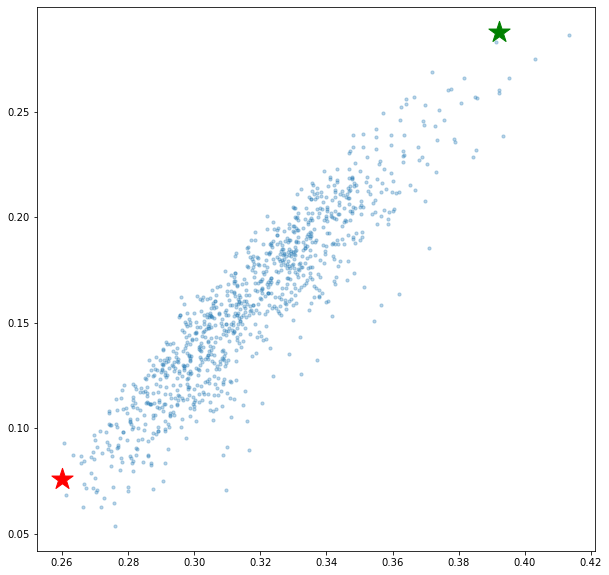

In [153]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)